<h1> Ligand Conformational Analysis Tutorial</h1>

<h3>IPython accepts some shell commands like ls or pwd.
First check whether you are in the correct directory</h3>

In [114]:
pwd

'/Users/dseelig/Documents/code/ITNLecture/notebooks'

<h3>The next lines import some modules we need for the analysis</h3>

In [115]:
import pyemma
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from glob import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import rdGeometry
from IPython.display import SVG
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = 400,400

Populating the interactive namespace from numpy and matplotlib


<h4> Define a function to make running averages</h4>

In [116]:
def smooth(x, window_len=11, window='hanning'):
    
    s = r_[2*x[0]-x[window_len:1:-1],x,2*x[-1]-x[-1:-window_len:-1]]
    w = eval( window+'(window_len)')
    y = convolve(w/w.sum(),s,mode='same')
    return y[window_len-1:-window_len+1]

In [117]:
def rmsd(m1, m2):
    rd = 0
    tm = float( len( m1.atoms ) )
    for a1, a2 in zip(m1.atoms,m2.atoms):
        for i in range(3):
            xd = a1.x[i] - a2.x[i]
            rd+= xd*xd
    return np.sqrt(rd/tm)

In [118]:
def plot_free_energy(xall, yall, weights=None, ax=None, nbins=100, offset=0.1, range=((-180,180),(-180,180)),
                     cmap='coolwarm_r', cbar=True, cbar_label='Free energy (kT)'):

    z, x, y = np.histogram2d(xall, yall, bins=nbins, weights=weights, range = range)
    z += offset
    # compute free energies
    F = -np.log(z)
    # do a contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    if ax is None:
        ax = gca()
    CS = ax.contourf(F.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = colorbar(CS)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax, gcf()


In [119]:
def computeDihedralAngle(mol, indices, conf_id = 0):
    c = mol.GetConformer(conf_id)
    pos = []
    for idx in indices:
        pos.append(c.GetAtomPosition(idx))
    phi = rdGeometry.ComputeSignedDihedralAngle(pos[0], pos[1], pos[2],pos[3])*180/np.pi
    return phi

def dihedralsFromConformers(mol, dih_list):
    mtx = np.zeros((len(list(mol.GetConformers())), len(dih_list)))
    for i, c in enumerate(list(mol.GetConformers())):
        for k, indices in enumerate(dih_list):
            v = computeDihedralAngle(mol, indices, conf_id = i)
            mtx[i,k] = v
    return mtx

In [120]:
#sd = Chem.SDMolSupplier('BI01591452.sdf')
#mol = Chem.MolFromMol2File('MOL.mol2')
mol = Chem.MolFromMolFile('../data/ligand_md/ligand.sdf', removeHs=False)
AllChem.Compute2DCoords(mol)

0

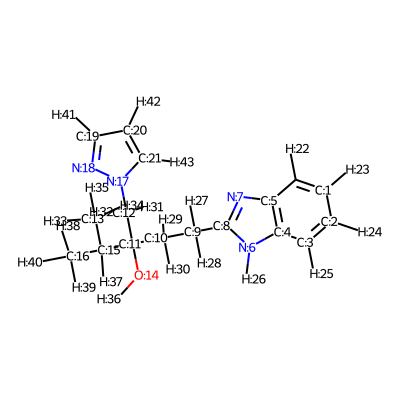

In [121]:
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())
mol

In [122]:
lst = []
lst.append( [7,8,9,10] )
lst.append( [8,9,10,11] )
lst.append( [9,10,11,14] )
lst.append( [14,11,12,17] )

In [123]:
mol2 = Chem.MolFromMolFile('../data/ligand_md/ligand.sdf', removeHs = False)
_ = AllChem.EmbedMultipleConfs(mol2, numConfs = 20)

In [124]:
mtx = dihedralsFromConformers(mol2, lst)

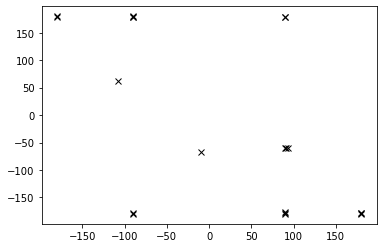

In [125]:
plot(mtx[:,0],mtx[:,1],'kx')

<h3> The first analysis we do is to compute dihedrals angles from the simulation data. Therefore we need to define the dihedral angles using the atom indices. First, read the pdb file:</h3>

<h3> Now we get the paths of the trajectories into a list. We also need a reference pdb file</h3>

In [126]:
from glob import glob
traj_list = glob('../data/ligand_md/*.xtc')
topfile = '../data/ligand_md/ligand.pdb'
print(traj_list)

['../data/ligand_md/run4.xtc', '../data/ligand_md/run2.xtc', '../data/ligand_md/run3.xtc', '../data/ligand_md/run1.xtc', '../data/ligand_md/run0.xtc']


<h3> The atom names which define a dihdral we get from a visualizer (pymol, moe). Then we can use the fetchm method to extract these atoms. Note that indices of python lists start at 0 whereas a pdb file starts with 1. We therefore have to decrement the atom id by 1.</h3>

In [127]:
lst = []
lst.append( [7,8,9,10] )
lst.append( [8,9,10,11] )
lst.append( [9,10,11,14] )
lst.append( [14,11,12,17] )
#lst.append( [] )



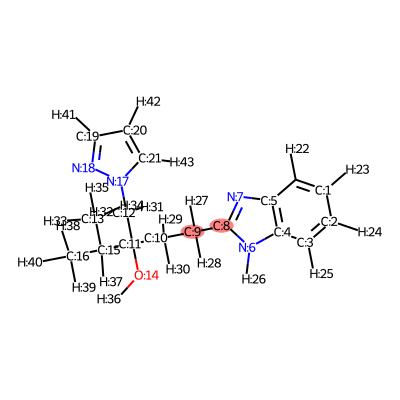

In [128]:
DrawingOptions.includeAtomNumbers = False
DrawingOptions.elemDict = {0:[0.5,0.5,0.5]}
DrawingOptions.bondLineWidth = 1.5
DrawingOptions.atomLabelFontSize = 16
Draw.MolToImage(mol, size=(400,400), highlightAtoms = lst[0][1:-1])

In [129]:
#Draw.MolToImageFile(mol,'dih1.png',size=(400,400), highlightAtoms = lst[0][1:-1])

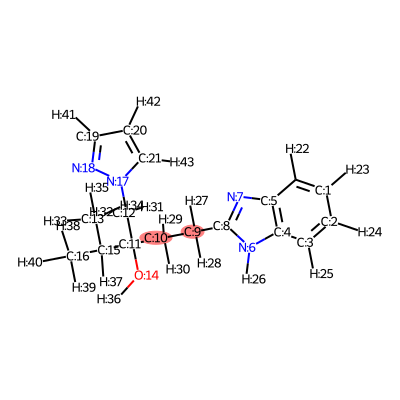

In [130]:

Draw.MolToImage(mol, size=(400,400), highlightAtoms = lst[1][1:-1])

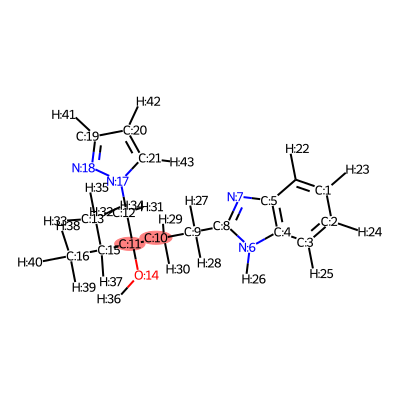

In [131]:
Draw.MolToImage(mol, size=(400,400), highlightAtoms = lst[2][1:-1])

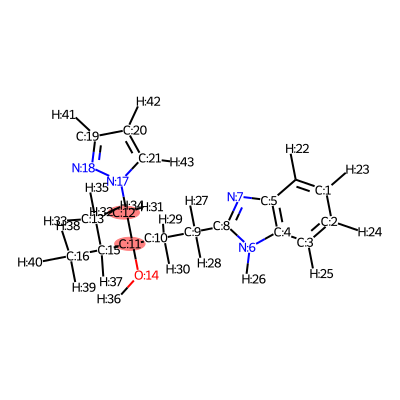

In [132]:
Draw.MolToImage(mol, size=(400,400), highlightAtoms = lst[3][1:-1])

<h3> Now we have a list which defines two dihedral angles.  In the next step we initialize a featurizer with our pdb file.</h3>

In [133]:
# pdb file
feat = coor.featurizer(topfile)

<h3> ..and add the list of dihedrals to the featurizer...</h3>

In [134]:
feat.add_dihedrals(lst)

<h3> In the next step we extract the features (the two dihedrals) from the trajectories<h3>

In [135]:
inp = coor.load(traj_list, feat)

Obtaining file info:   0%|                                                                     | 0/5 [00:00<?,…

getting output of FeatureReader:   0%|                                                         | 0/5 [00:00<?,…

<h3> inp is a list of arrays containing the extracted features. inp[0] contains the data from the first trajectory, inp[-1] the data from the last.</h3> 

In [137]:
#inp

<h3> Now we plot a 2d histogram of the two dihedral angles.</h3>

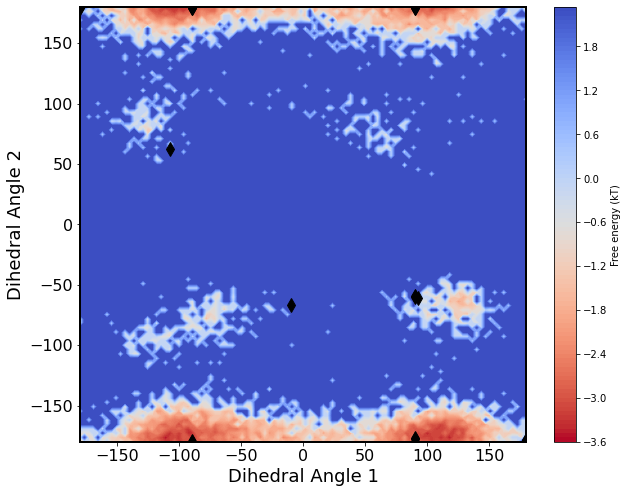

In [141]:
figure(figsize=(10,8))
#mplt.plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
for p in gca().spines.values(): p.set_lw(2)
#plot(ref_1, ref_2,'ko', markersize=10)
#text(ref_1, ref_2+20,"Xray Dihedrals", fontsize=20)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Dihedral Angle 1', fontsize=18)
ylabel('Dihedral Angle 2', fontsize=18)
xlim(-180,180)
ylim(-180,180)
plot(mtx[:,0],mtx[:,1],'kd', markersize=10)
#savefig('dih1_vs_dih2.png', bbox_inches = 'tight')

(-180.0, 180.0)

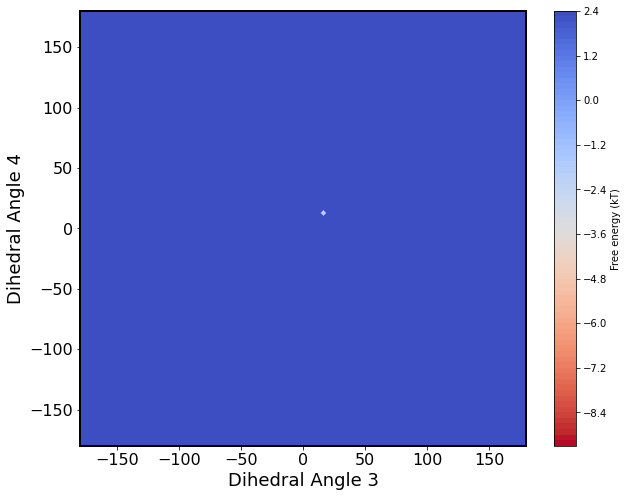

In [113]:
figure(figsize=(10,8))
#mplt.plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
plot_free_energy(np.vstack(inp)[:,2]*180./pi,np.vstack(inp)[:,3]*180./pi, offset = 0.1)
for p in gca().spines.values(): p.set_lw(2)
#plot(ref_1, ref_2,'ko', markersize=10)
#text(ref_1, ref_2+20,"Xray Dihedrals", fontsize=20)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Dihedral Angle 3', fontsize=18)
ylabel('Dihedral Angle 4', fontsize=18)
xlim(-180,180)
ylim(-180,180)
#plot(mtx[:,0],mtx[:,1],'kx')
#savefig('dih3_vs_dih4.png', bbox_inches = 'tight')

<h3> In the next cell we plot a histogram along the amid angle</h3>

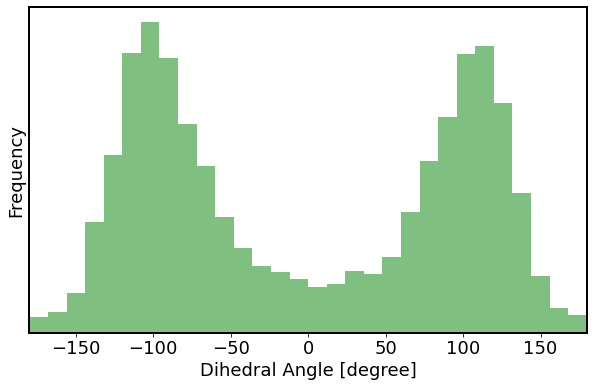

In [56]:
figure(figsize=(10,6))
ref = -13.
n, b, p = hist(np.vstack(inp)[:,0]*180./pi, bins=30, color = 'g', alpha=.5)
for p in gca().spines.values(): p.set_lw(2)
yticks([]);
#savefig('dih1_histogram.png', bbox_inches = 'tight')
xlim(-180,180);
xticks(fontsize=18);
xlabel('Dihedral Angle [degree]', fontsize=18);
ylabel('Frequency', fontsize=18);
#plot([ref,ref],[0,max(n)*.7],'k-')
#text(ref-40, max(n)*.8,'Xray Dihedral', fontsize=16)

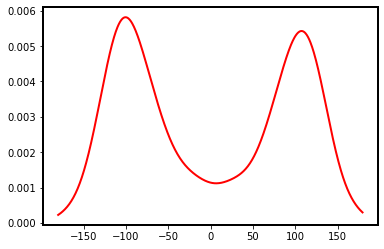

In [57]:
from scipy.stats import gaussian_kde
kernel = gaussian_kde(np.vstack(inp)[:,0]*180./pi)
xr = arange(-180, 180,.5)
y_kde = kernel.evaluate(xr)
plot(xr,y_kde,'r-',lw=2)
for p in gca().spines.values(): p.set_lw(2)

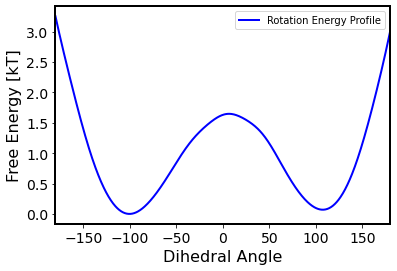

In [58]:
energy = -log(y_kde)
nenergy = energy - min( energy )
plot(xr, nenergy, 'b-',lw=2, label = 'Rotation Energy Profile')
xlim(-180,180)
xlabel('Dihedral Angle',fontsize=16)
ylabel('Free Energy [kT]',fontsize=16)
#grid(lw=2)
xticks( fontsize=14)
yticks( fontsize=14)
legend( loc='upper right')
for p in gca().spines.values(): p.set_lw(2)
#savefig('dihedral1_energy.png')

<h3> Clustering and Selection of Conformers</h3>

In [65]:
dist_lst = []
lst =  list(mol.GetAtoms())
for i, a1 in enumerate(lst[:-1]):
    for a2 in lst[i+1:]:
        dist_lst.append([a1.GetIdx(), a2.GetIdx()])

    

In [66]:
feat3 = coor.featurizer(topfile)
feat3.add_distances(dist_lst)
#feat3.describe()

In [67]:
inp = coor.load(traj_list, feat3)
source = coor.source( traj_list, top = topfile )

Obtaining file info:   0%|                                                                     | 0/5 [00:00<?,…

getting output of FeatureReader:   0%|                                                         | 0/5 [00:00<?,…

Obtaining file info:   0%|                                                                     | 0/5 [00:00<?,…

<h3> KMeans clustering on intramolecular distances</h3>

In [68]:
n_clusters = 20
cl_obj = coor.cluster_kmeans(inp, k=n_clusters)

initialize kmeans++ centers:   0%|                                                            | 0/20 [00:00<?,…

kmeans iterations:   0%|                                                                      | 0/10 [00:00<?,…

26-07-21 10:14:52 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [69]:
# Generate samples from each cluster
samples = cl_obj.sample_indexes_by_cluster(range(n_clusters),1)
out_name_base = '../data/ligand_md/cluster'
out_names = []
for i in range(n_clusters):
    out_names.append( out_name_base+'%d.pdb' % i)
#print out_names

getting output of KmeansClustering:   0%|                                                      | 0/5 [00:00<?,…

In [70]:
# save cluster representatives
coor.save_trajs(source, samples, outfiles = out_names)



['../data/ligand_md/cluster0.pdb',
 '../data/ligand_md/cluster1.pdb',
 '../data/ligand_md/cluster2.pdb',
 '../data/ligand_md/cluster3.pdb',
 '../data/ligand_md/cluster4.pdb',
 '../data/ligand_md/cluster5.pdb',
 '../data/ligand_md/cluster6.pdb',
 '../data/ligand_md/cluster7.pdb',
 '../data/ligand_md/cluster8.pdb',
 '../data/ligand_md/cluster9.pdb',
 '../data/ligand_md/cluster10.pdb',
 '../data/ligand_md/cluster11.pdb',
 '../data/ligand_md/cluster12.pdb',
 '../data/ligand_md/cluster13.pdb',
 '../data/ligand_md/cluster14.pdb',
 '../data/ligand_md/cluster15.pdb',
 '../data/ligand_md/cluster16.pdb',
 '../data/ligand_md/cluster17.pdb',
 '../data/ligand_md/cluster18.pdb',
 '../data/ligand_md/cluster19.pdb']

<h3> Cluster Statistics</h3>

<h4> Generate 1-dim array of all discretized (assigned to a cluster) trajectories</h4>

In [71]:
ii = np.concatenate(cl_obj.dtrajs)
#ii = np.vstack(cl_obj.dtrajs).flatten()

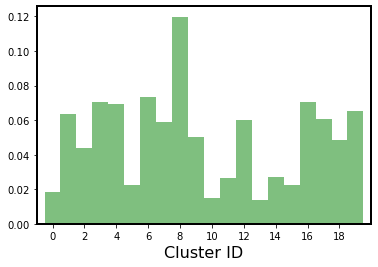

In [77]:
occupancy,b,p = hist(ii,bins=n_clusters,range=(-.5, 19.5),color='g',alpha=.5, density=True)
xlim(-1,n_clusters)
xticks( range(0,n_clusters,2))
xlabel('Cluster ID', fontsize=16)
for p in gca().spines.values(): p.set_lw(2)

In [74]:
lst  = glob('../data/ligand_md/cluster*.pdb')

In [ ]:
rmsd_mat = np.zeros( len(lst)**2).reshape( (len(lst),len(lst)))
for i, f1 in enumerate(lst[:-1]):
    for k, f2 in enumerate(lst[i+1:]):
        id1 = int(f1.split('.')[0].split('cluster')[1])
        id2 = int(f2.split('.')[0].split('cluster')[1])
        m1 = Model( f1 )
        m2 = Model( f2 )
        fit_atoms( m1.atoms, m2.atoms, m2.atoms )
        dd = rmsd( m1, m2 )
        rmsd_mat[id1][id2] = dd




In [ ]:
import networkx as nx
G = nx.Graph()
cutoff = 0.8
for i in range( n_clusters ):
    G.add_node(i)
for i in range( n_clusters-1 ):
    for k in range( i+1, n_clusters):
        rm = rmsd_mat[i][k]
        if rm <= cutoff:
            G.add_edge( i,k )
#            dic[i].append( k )
#            print i, k
#        print i, k, rmsd_mat[i][k]
print G#print dic   

In [ ]:
#nx.clustering(G)
#print occupancy
atoms_to_fit = ['C1','C2','C3']#,'C9']
ref_conf = Model('cluster0.pdb')
ref_atoms = ref_conf.residues[0].fetchm(atoms_to_fit)

cluster_lst = []
for cluster_ids in nx.connected_components(G):
    occ = 0
    for idx in cluster_ids:
        occ += occupancy[idx]
    cluster_lst.append( [cluster_ids, occ] )

sorted_cluster_lst =  sorted( cluster_lst, lambda a,b: cmp(b[1],a[1]) )


fpp = open('clusters_stats.txt','w')
for i, (ids, occ) in enumerate(sorted_cluster_lst):
    fp = open('MetaCluster%d.pdb' % i,'w')
    print >>fpp, 'MetaCluster%d.pdb -> Population = %4.2f%%' % (i,occ*100)
    for k, ii in enumerate(ids):
        fn = 'cluster%d.pdb' % ii
        m = Model(fn)
        atoms = m.residues[0].fetchm( atoms_to_fit )
        fit_atoms( ref_atoms, atoms, m.atoms )
        print >>fp, 'MODEL%5d' % k
        for atom in m.atoms:
            print >>fp, atom
        print >>fp, 'ENDMDL'
    fp.close()
fpp.close()


    #    print cluster_ids, occ

In [78]:
from rdkit.Geometry import rdGeometry

In [80]:
c = mol.GetConformer(0)

'../data/ligand_md/cluster0.pdb'

In [91]:
pos = []
for idx in lst[2]:
    pos.append(c.GetAtomPosition(idx))


In [95]:
rdGeometry.ComputeDihedralAngle(pos[0], pos[1], pos[2],pos[3])*180/np.pi

180.0

In [94]:
#rdGeometry.ComputeDihedralAngle?